# IEEE- FRAUD DETECTION USING FULLY CONNECTED NEURAL NETWORKS AND FASTAI

## Load packages

In [1]:
from fastai.tabular.all import *
from utils.data import export
from sklearn.metrics import roc_auc_score

## Load the dataset & artifacts

In [2]:
df = pd.read_csv('data/train-balance.csv', low_memory=False)

with open('artifacts/features.txt') as json_file:
        features = json.load(json_file)

cont = features['cont']
cat = features['cat']
dep_var = features['dep_var']
cols = cat+cont+[dep_var]

df = df[cols]
df[dep_var] = df[dep_var].astype(str)
df = df.sort_values(by=['TransactionDT'])
pct = int(df.shape[0]*(100-(0.2*100))/100)
splits = (list(df[:pct].index),list(df[pct:].index))

procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df, procs_nn, cat, cont, splits=splits, y_names=dep_var)
to_nn.export('artifacts/to_nn.pkl')

## Build the model

In [3]:
dls = to_nn.dataloaders(1024)

In [4]:
def roc(inp, targ):
    "Simple wrapper around scikit's roc_auc_score function for regression problems"
    inp,targ = flatten_check(inp,targ)
    return roc_auc_score(targ.cpu().numpy(), inp.cpu().numpy())

In [5]:
learn = tabular_learner(dls, layers=[200,100], metrics=accuracy)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.007585775572806597)

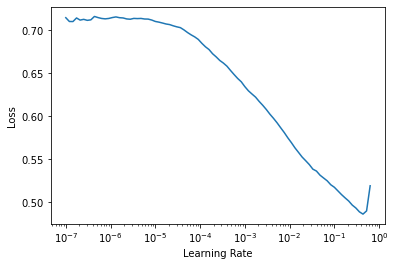

In [6]:
learn.lr_find()

In [7]:
learn.fit_one_cycle(6, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.404596,0.348815,0.867834,00:38
1,0.327149,0.281886,0.884240,00:38
2,0.270266,0.252202,0.902120,00:38
3,0.223370,0.234762,0.910138,00:38
4,0.182491,0.235126,0.911429,00:38
5,0.149908,0.241877,0.912719,00:38


In [8]:
probs,predictions = learn.get_preds()

In [9]:
roc_auc_score(torch.flatten(predictions).numpy(),probs.argmax(dim=-1))

0.8786268458648825

## Fit the model to the test set

In [10]:
df_test = pd.read_csv('data/test.csv', low_memory=False)

In [11]:
to_tst = to_nn.new(df_test)
to_tst.process()
tst_dl = dls.valid.new(to_tst)

In [12]:
preds, _= learn.get_preds(dl=tst_dl)

In [13]:
df_test['isFraud'] = preds[:,1].cpu().numpy()

In [14]:
df_test[df_test['TransactionID'].duplicated()]

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,day,hour,id_31_v,isFraud


## Submit the result to Kaggle for evaluation

In [15]:
df_test[['TransactionID', 'isFraud']].to_csv('data/submission_nn_v1.csv', index=False)

In [16]:
!kaggle competitions submit -c ieee-fraud-detection -f data/submission_nn_v1.csv -m "first submission without any deep feature engineering. just using fastai and xgboost"

100%|██████████████████████████████████████| 9.73M/9.73M [00:08<00:00, 1.26MB/s]
Successfully submitted to IEEE-CIS Fraud Detection